In [1]:
import torch
from PIL import Image
from IPython.display import display
from GradCam import GradCamForVQA
from vqa.ResnetVQA import VQAProcessor, VisualResnetForQuestionAnswering, wrap_model

/home/hyeongchanim/anaconda3/envs/llava/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
processor = VQAProcessor('vqa/models/processor.pth', device)
model = VisualResnetForQuestionAnswering(processor, device)
model = wrap_model(model)

In [4]:
model

DataParallel(
  (module): ModelInputWrapper(
    (module): VisualResnetForQuestionAnswering(
      (text): TextProcessor(
        (embedding): Embedding(15193, 300, padding_idx=0)
        (drop): Dropout(p=0.5, inplace=False)
        (tanh): Tanh()
        (lstm): LSTM(300, 1024)
      )
      (attention): Attention(
        (v_conv): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (q_lin): Linear(in_features=1024, out_features=512, bias=True)
        (x_conv): Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
        (drop): Dropout(p=0.5, inplace=False)
        (relu): ReLU(inplace=True)
      )
      (classifier): Classifier(
        (drop1): Dropout(p=0.5, inplace=False)
        (lin1): Linear(in_features=5120, out_features=1024, bias=True)
        (relu): ReLU()
        (drop2): Dropout(p=0.5, inplace=False)
        (lin2): Linear(in_features=1024, out_features=3000, bias=True)
      )
      (vqa_net): DataParallel(
        (module): Net(
          (text):

In [5]:
layer = model.module.module.resnet_layer4.r_model.layer4

In [6]:
gc = GradCamForVQA(model, layer, processor, device)

Cannot peform backprop on RNN if torch.backends.cudnn.enabled
Disabling...


In [13]:
image = Image.open("/data/hyeongchanim/Grad-CAM/sample_images/vqa_images/test/texting.jpg")
question = "What is she doing?"

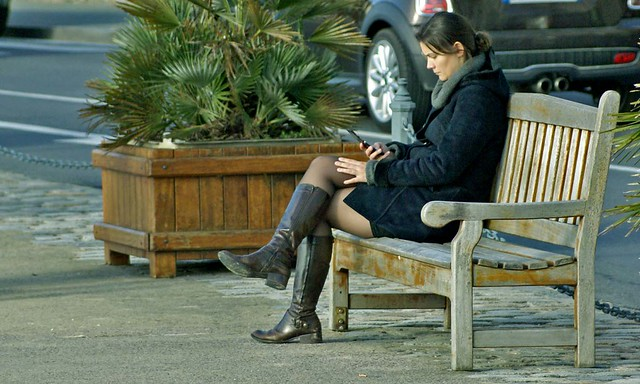

Question: What is she doing?
Answer: texting


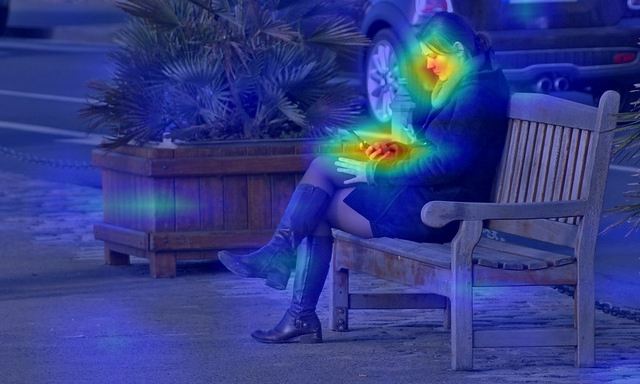

In [14]:
display(image)
print(f"Question: {question}")
gc(image, question)